In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Use Inspector to print the column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Use Inspector to print the column names and types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame, set the index to the date column, and sort by Date
prcp_df = pd.DataFrame(result, columns=['Date', 'Precipitation']).sort_values(['Date'])
prcp_df = prcp_df.set_index("Date")
prcp_df = prcp_df.dropna(how='any')
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


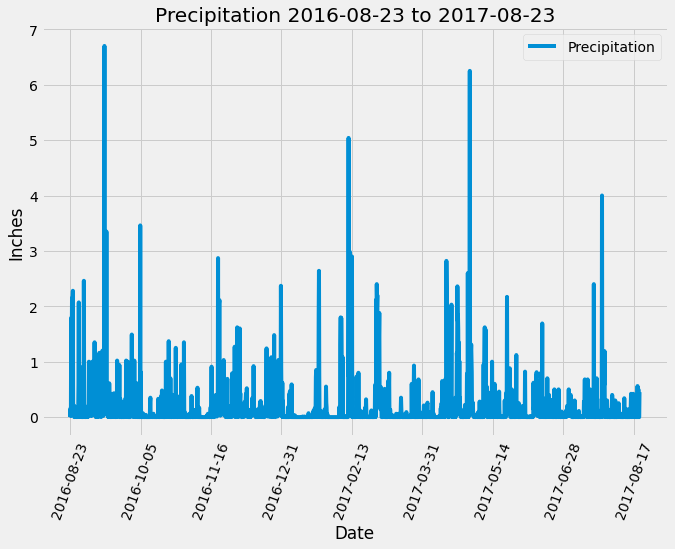

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = prcp_df.plot(rot=70, ylabel='Inches', title=f'Precipitation {year_ago} to 2017-08-23', figsize=(10, 7))
plt.savefig('precipitation_analysis.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = round(prcp_df.describe(), 2)
summary_stats.head()

,Precipitation
count,2021.00
mean,0.18
std,0.46
min,0.00
25%,0.00


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()
print(f'There are {station_count} stations in the dataset')

There are 9 stations in the dataset


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_most = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
station_most

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
pop_station = 'USC00519281'
pop_station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
func.avg(Measurement.tobs)).filter(Measurement.station == pop_station).all()
print(f"The {pop_station} station's lowest, highest, and average temperatures are {pop_station_stats}.")


The USC00519281 station's lowest, highest, and average temperatures are [(54.0, 85.0, 71.66378066378067)].


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station  Measurement.date,     .order_by(Measurement.date)
pop_station_year = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == pop_station).all()
station_df = pd.DataFrame(pop_station_year, columns=['Temperature'])
station_df.head()

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


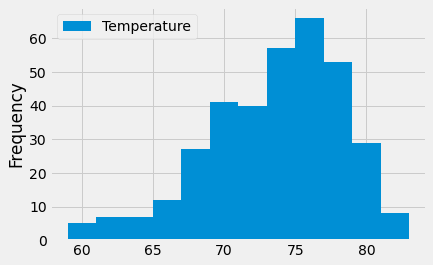

In [22]:
#Plot the results from pop_station_year in a histogram
histogram = station_df.plot.hist(bins=12)
plt.savefig('MostPopStationTemps_Histogram.png')
plt.show()

# Close session

In [23]:
# Close Session
session.close()